# Make figures for DF project

* Number fluctuation at different bacterial concentration
20, 40, 60, 80 and 100 n$_0$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
from corrLib import corrS, corrI, divide_windows, distance_corr, corrIseq, readseq, match_hist
from scipy.signal import savgol_filter
import matplotlib as mpl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal
from scipy.interpolate import griddata
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import SI_LENGTH

## Functions
* These functions will be collected in a library later

In [4]:
def readdata(folder):
    dataDirs = dirrec(folder, '*.csv')
    nameList = []
    dirList = []
    for dataDir in dataDirs:
        path, file = os.path.split(dataDir)
        name, ext = os.path.splitext(file)
        nameList.append(name)
        dirList.append(dataDir)
    fileList = pd.DataFrame()
    fileList = fileList.assign(Name=nameList, Dir=dirList)
    fileList = fileList.sort_values(by=['Name'])
    return fileList

In [5]:
def average_NF(folder, avrange=[250, 500]):
    l = readdata(folder)
    count = 0
    for num, i in l.iterrows():
        if int(i.Name) < avrange[0] or int(i.Name) > avrange[1]:
            continue
        tmp = pd.read_csv(i.Dir)
        if count == 0:
            data = tmp
        else:
            data += tmp
        count += 1
    return data / count

In [6]:
def corrlength(corrData, deg, fitting_range=1000):
    xx = np.array(corrData.R)
    yy = np.array(corrData.C)
    x = xx[xx<fitting_range]
    y = yy[xx<fitting_range]
    p = np.polyfit(x, y, deg)
    xsolve = np.linspace(0, x.max(), int(x.max()))
    yfit = np.dot(polyvander(xsolve, deg), np.flip(p).transpose())
    for xm, ym in zip(xsolve, yfit):
        if ym > (1 / np.e):
            continue
        else:
            return xm

In [7]:
def average_cav(folder):
    l = readdata(folder)
    count = 0
    for num, i in l.iterrows():
        tmp = pd.read_csv(i.Dir)
        if count == 0:
            data = tmp
        else:
            data += tmp
        count += 1
    return data / count

## Figure implementations

#### Figure 1 - experiment
* Raw image from microscopy
* <del>Spatial intensity variation</del>
* PIV overlay
* Correlation between velocity magnitude and light intensity

(-0.5, 2047.5, 2047.5, -0.5)

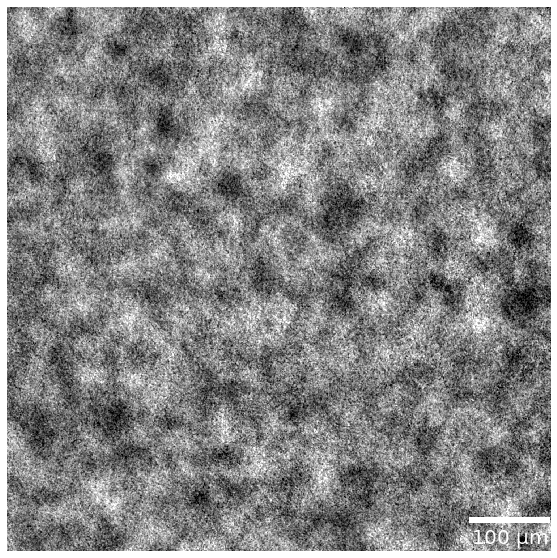

In [260]:
# Load raw image
%matplotlib inline
imgDir = r'I:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\80-900.tif'
img = io.imread(imgDir)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img, cmap='gray')
scalebar = ScaleBar(0.33, 'um', SI_LENGTH, frameon=False, color='white', font_properties={'size': 20},
                   pad=0, location='lower right', fixed_value=100) # 1 pixel = 0.2 1/cm
ax.add_artist(scalebar)
plt.axis('off')

(-0.5, 2047.5, 2047.5, -0.5)

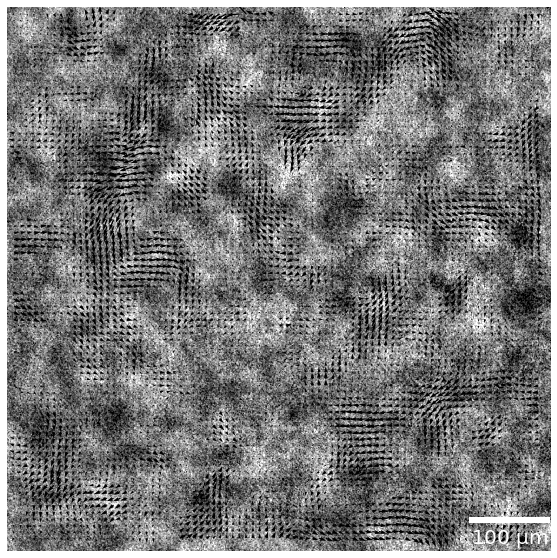

In [259]:
# PIV overlay, vortex size > cluster size
imgDir = r'I:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\80-900.tif'
img = io.imread(imgDir)
pivData = pd.read_csv(r'D:\Wei\Dynamics_raw\piv_result_50\80\900-901.csv')
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img, cmap='gray')
ax.quiver(pivData.x, pivData.y, pivData.u, pivData.v)
scalebar = ScaleBar(0.33, 'um', SI_LENGTH, frameon=False, color='white', font_properties={'size': 20},
                   pad=0, location='lower right', fixed_value=100) # 1 pixel = 0.2 1/cm
ax.add_artist(scalebar)
plt.axis('off')

In [249]:
# PIV overlay, make arrows sparcer
pivData = pd.read_csv(r'D:\Wei\Dynamics_raw\piv_result_50\80\900-901.csv')
col = len(pivData.x.drop_duplicates())
row = len(pivData.y.drop_duplicates())
x = np.array(pivData.x).reshape(row, col)
y = np.array(pivData.y).reshape(row, col)
u = np.array(pivData.u).reshape(row, col)
v = np.array(pivData.v).reshape(row, col)
xs = x[0:row:2, 0:col:2]
ys = y[0:row:2, 0:col:2]
us = u[0:row:2, 0:col:2]
vs = v[0:row:2, 0:col:2]

(-0.5, 2047.5, 2047.5, -0.5)

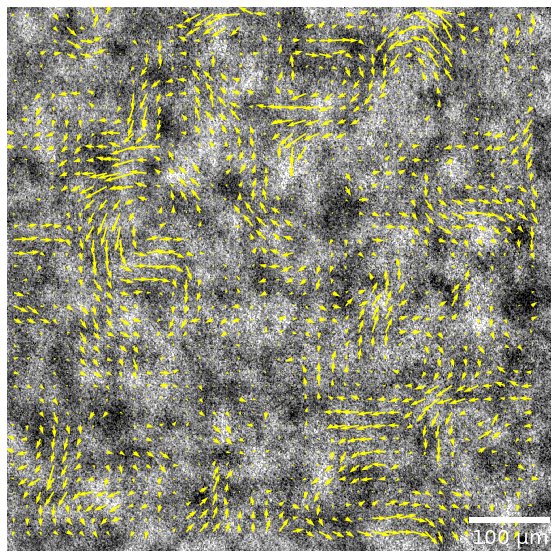

In [258]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img, cmap='gray')
ax.quiver(xs, ys, us, vs, color='yellow', width=0.003)
scalebar = ScaleBar(0.33, 'um', SI_LENGTH, frameon=False, color='white', font_properties={'size': 20},
                   pad=0, location='lower right', fixed_value=100) # 1 pixel = 0.2 1/cm
ax.add_artist(scalebar)
plt.axis('off')

In [262]:
# Show how velocity magnitude correlates with light intensity
imgDir = r'I:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\80-900.tif'
img = io.imread(imgDir)
X, Y, I = divide_windows(img, windowsize=[50, 50], step=25)
pivmag = (u**2 + v**2) ** .5

In [285]:
I = I / I.max()
pivmag = pivmag / pivmag.max()
corr = (I - I.mean()) * (pivmag - pivmag.mean())

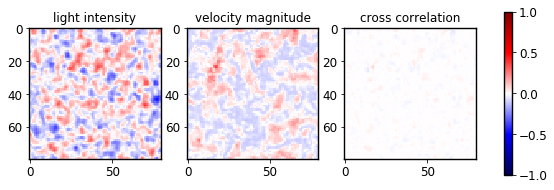

In [289]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
z0 = ax[0].imshow(I - I.mean(), cmap='seismic', vmax=1, vmin=-1)
ax[0].set_title('light intensity')
ax[1].imshow(pivmag - pivmag.mean(), cmap='seismic', vmax=1, vmin=-1)
ax[1].set_title('velocity magnitude')
ax[2].imshow(corr, cmap='seismic', vmax=1, vmin=-1)
ax[2].set_title('cross correlation')
plt.colorbar(z0, ax=ax)

In [284]:
I

array([[32665.1428, 40297.4408, 41344.4716, ..., 35415.972 , 38012.4576,
        39276.456 ],
       [36663.2504, 44118.6252, 46243.9636, ..., 35832.7472, 43126.3368,
        45858.5248],
       [35605.8504, 43182.5176, 46444.4708, ..., 37416.9792, 43589.0564,
        45914.742 ],
       ...,
       [31026.7848, 28168.6908, 26105.818 , ..., 33956.6328, 30491.27  ,
        34256.1944],
       [33538.272 , 28986.622 , 25873.0268, ..., 29398.5604, 31225.2632,
        38929.0608],
       [35246.6964, 28254.6936, 25388.1056, ..., 18912.3264, 27416.748 ,
        36644.71  ]])

In [273]:
pivmag.mean()

45.19860748282372

#### Figure 2 - GNF
* Deviation from CLT
* Slope vs. concentration

In [17]:
folders = [r'D:\Wei\Dynamics_raw\df_result\20',
           r'D:\Wei\Dynamics_raw\df_result\40',
           r'D:\Wei\Dynamics_raw\df_result\60',
           r'D:\Wei\Dynamics_raw\df_result\80',
           r'D:\Wei\Dynamics_raw\df_result\100']
data = pd.DataFrame()
for f in folders:
    a = average_NF(f, avrange=[400, 1000])
    name = int(os.path.split(f)[1])
    a = a.assign(Name=name)
    data = data.append(a)

In [19]:
data.to_csv(r'I:\Google Drive\Research projects\DF\Figures\fig2-GNF\GNF_data.csv', index=False)

Text(0, 0.5, '$\\Delta N/N^{0.5}$')

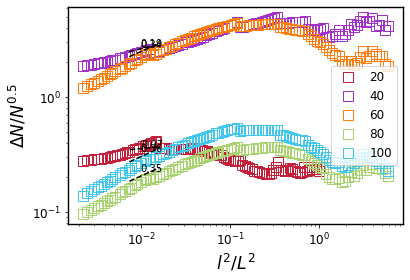

In [10]:
# GNF data
# Normalization of data is needed 
count = 0
slopeL = []
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]    
    # to plot, xx yy
    xx = subdata.n/420**2
    yy = subdata.d/subdata.n**.5       
    plt.plot(xx, yy, label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    # to fit
    x = xx.loc[subdata.n<1e4]
    y = yy.loc[subdata.n<1e4] 
    xf, yf, xt, yt, slope = label_slope(x, y, location='n')
    plt.plot(xf, yf, ls='--', color='black')
    plt.text(xt, yt, '{:.2f}'.format(slope))
    count += 1
    slopeL.append(slope)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/L^2$')
plt.ylabel('$\Delta N/N^{0.5}$')

Fig 2 revise
* rescale x with bacteria size
* rescale y by forcing first value to be 1
* make sparcer
* delete slope annotation

Text(0, 0.5, '$\\Delta N/N^{0.5}$')

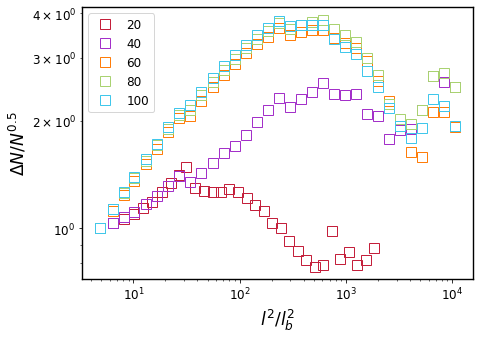

In [20]:
# Fig2, r1
plt.figure(figsize=(7, 5))
lb = 3 # um
mpp = 0.33 
count = 0
slopeL = []
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]    
    # to plot, xx yy
    xx = subdata.n / (lb/mpp)**2
    yy = subdata.d / subdata.n**.5 
    yy = yy / yy[0]
    plt.plot(xx[0:len(xx):3], yy[0:len(yy):3], label=str(name), ls='', marker='s',
            mfc=(0,0,0,0), mec=wowcolor(count), markersize=10)
    # to fit
    x = xx.loc[xx<2e1]
    y = yy.loc[xx<2e1] 
    xf, yf, xt, yt, slope = label_slope(x, y, location='n')
#     plt.plot(xf, yf, ls='--', color='black')
#     plt.text(xt, yt, '{:.2f}'.format(slope))
    count += 1
    slopeL.append(slope)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l^2/l_b^2$')
plt.ylabel('$\Delta N/N^{0.5}$')

Text(0, 0.5, 'slope')

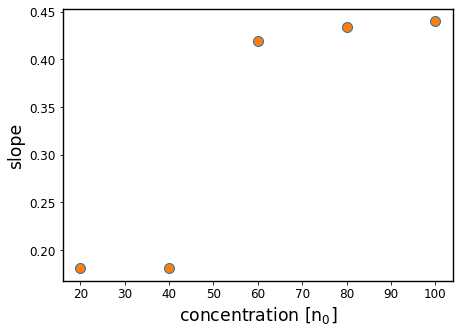

In [21]:
n = [20, 40, 60, 80, 100]
plt.figure(figsize=(7, 5))
plt.plot(n, slopeL, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('slope')

Fig 2 new data
* Shows tiny difference between different concentrations, which is inconsistent with last data set, need to look into it. This could be a result from different bpass parameters. 100 px as high bpass bound gives better distinct between low concentration and high concentration. 500 px as high bpass bound usually leads to the dominance of long wavelength illumination inhomogeneity. 

In [11]:
folder = r'F:\data\02042020\df_result'
s = ['20-1', '20-2', '20-3', '40-1', '40-2', '40-3',  
     '60-1', '60-2', '60-3', '80-1', '80-2', '80-3']
data = pd.DataFrame()
for subfolder in s:
    f = os.path.join(folder, subfolder)
    a = average_NF(f, avrange=[0, 1000])
    name = os.path.split(f)[1]
    a = a.assign(Name=name)
    data = data.append(a)

In [12]:
data.to_csv(r'I:\Google Drive\Research projects\DF\Figures\fig2-GNF\GNF_0204.csv', index=False)

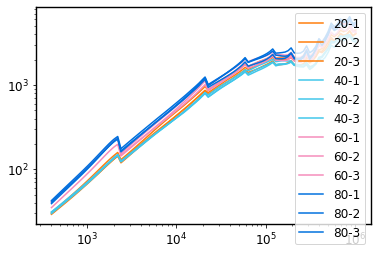

In [13]:
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig2-GNF\GNF_0204.csv')
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]
    plt.plot(subdata.n, subdata.d, color=wowcolor(int(name[0])), label=name)
plt.xscale('log')
plt.yscale('log')
plt.legend()

#### Figure 3 - intensity spatial correlation
* correlation vs. distance
* correlation length vs. concentration

In [309]:
# Average over 100 frames
folder = r'D:\Wei\Dynamics_raw\cl_result'
n = [20, 40, 60, 80, 100]
data = pd.DataFrame()
for nt in n:    
    subdata = average_NF(os.path.join(folder, str(nt)), avrange=[400, 1000])
    data = data.append(subdata.assign(conc=nt))

Text(0, 0.5, 'Correlation')

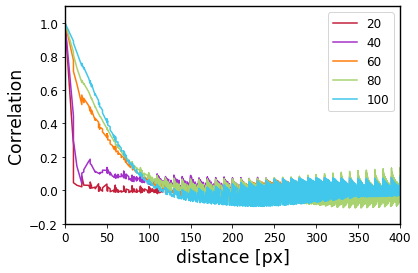

In [34]:
# Plot raw data
count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    plt.plot(subdata.R, subdata.C, color=wowcolor(count), label=str(nt))
    count += 1
plt.legend()
plt.axis([0, 400, -0.2, 1.1])
plt.xlabel('distance [px]')
plt.ylabel('Correlation')

Text(0, 0.5, 'Correlation')

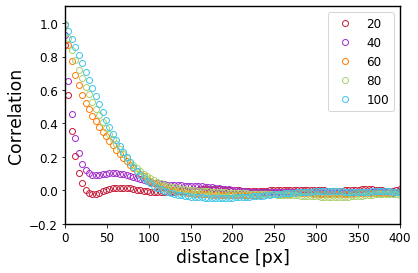

In [48]:
# Polynomial fitting in range
deg = 10 # degree of polynomial fitting
sparcity = 4 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')

count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    x = subdata.R
    y = subdata.C
    p = np.polyfit(x, y, deg)
    xfit = np.linspace(0, x.max(), int(x.max()/sparcity))
    yfit = np.dot(polyvander(xfit, deg), np.flip(p).transpose())
    plt.plot(xfit, yfit, mec=wowcolor(count), label=str(nt), ls='',
            marker='o', mfc=(0,0,0,0))
    count += 1
plt.legend()
plt.axis([0, 400, -0.2, 1.1])
plt.xlabel('distance [px]')
plt.ylabel('Correlation')

Text(0, 0.5, 'correlation')

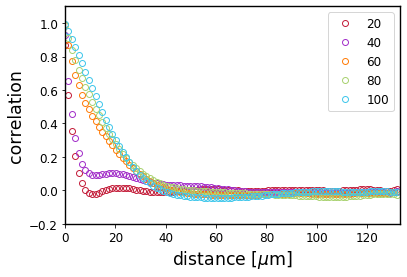

In [315]:
# Convert unit to um
deg = 10 # degree of polynomial fitting
sparcity = 4 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
mpp = 0.33

count = 0
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    x = subdata.R
    y = subdata.C
    p = np.polyfit(x, y, deg)
    xfit = np.linspace(0, x.max(), int(x.max()/sparcity))
    yfit = np.dot(polyvander(xfit, deg), np.flip(p).transpose())
    plt.plot(xfit*mpp, yfit, mec=wowcolor(count), label=str(nt), ls='',
            marker='o', mfc=(0,0,0,0))
    count += 1
plt.legend()
plt.axis([0, 133, -0.2, 1.1])
plt.xlabel('distance [$\mu$m]')
plt.ylabel('correlation')

In [339]:
# compute errorbar of intensity correlation function, err = 0.05
stdL = []
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    cropdata = subdata.C.loc[(subdata.R>350)&(subdata.R<400)]
    std = cropdata.std()
    stdL.append(std)
err = np.array(stdL).max()
err

0.053544800210060244

Text(0, 0.5, 'correlation length [$\\mu$m]')

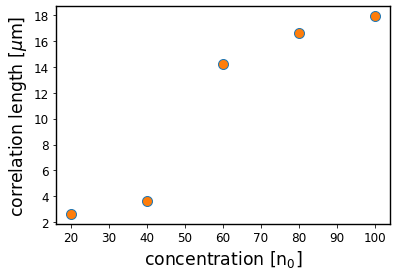

In [29]:
# Extract correlation length - based on polynomial fitting
deg = 8 # degree of polynomial fitting
sparcity = 1 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
mpp = 0.33

n = [20, 40, 60, 80, 100]
cl = []
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    cl.append(corrlength(subdata, 10))
plt.plot(n, np.array(cl)*mpp, ls='', marker='o', mfc=wowcolor(2),
        markersize=10, lw='2')
plt.xlabel('concentration [n$_0$]')
plt.ylabel('correlation length [$\mu$m]')

In [39]:
# Save data
# data.to_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv', index=False)

New data for correlations

In [16]:
folder = r'F:\data\02042020\cl_result'
s = ['20-1', '20-2', '20-3', '40-1', '40-2', '40-3',  
     '60-1', '60-2', '60-3', '80-1', '80-2', '80-3']
data = pd.DataFrame()
for subfolder in s:
    print(subfolder)
    f = os.path.join(folder, subfolder)
    subdata = average_NF(folder, avrange=[0, 1000])
    subdata = subdata.assign(Name=subfolder)
    data = data.append(subdata)

20-1
20-2
20-3
40-1
40-2
40-3
60-1
60-2
60-3
80-1
80-2
80-3


In [17]:
data.to_csv(r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\intensity_new.csv', index=False)

[0, 400, -0.2, 1]

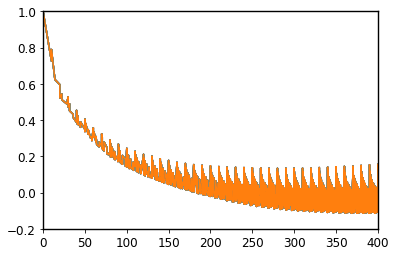

In [19]:
for name in data.Name.drop_duplicates():
    subdata = data.loc[data.Name==name]
    plt.plot(subdata.R, subdata.C)
plt.axis([0, 400, -0.2, 1])

#### Figure 4 - velocity and orientation spatial correlation
* <del>velocity correlation 2D</del>
* velocity correlation length vs. concentration
* <del>orientation correlation 2D</del>
* orientation correlation length vs. concentration

In [2]:
# From PIV to correlation
folder = r'D:\Wei\Dynamics_raw\piv_result\100'
pivData = pd.read_csv(os.path.join(folder, '900-901.csv'))
col = len(pivData.x.drop_duplicates())
row = len(pivData.y.drop_duplicates())
X = np.array(pivData.x).reshape((row, col))
Y = np.array(pivData.y).reshape((row, col))
U = np.array(pivData.u).reshape((row, col))
V = np.array(pivData.v).reshape((row, col))
CA, CV = corrS(X, Y, U, V)

In [348]:
# Large volume data
folder = r'D:\Wei\Dynamics_raw\cav_result_50\20'
data = average_cav(folder)

In [349]:
save_dir = r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr'
row = len(data.Y.drop_duplicates())
col = len(data.X.drop_duplicates())
X = np.array(data.X).reshape(row, col)
Y = np.array(data.Y).reshape(row, col)
CA = np.array(data.CA).reshape(row, col)
CV = np.array(data.CV).reshape(row, col)
dc = distance_corr(X, Y, CV)
dc.to_csv(os.path.join(save_dir, 'CV20.csv'), index=False)

In [188]:
# Crop and save data
CA = np.array(data.CA).reshape(80, 80)[0:30, 0:30]
CV = np.array(data.CV).reshape(80, 80)[0:30, 0:30] * 6400
save_folder = r'I:\Google Drive\Research projects\DF\Figures\fig4-VACorr'
np.savetxt(os.path.join(save_folder, 'CA040.dat'), CA)
np.savetxt(os.path.join(save_folder, 'CV040.dat'), CV)

<IPython.core.display.Javascript object>


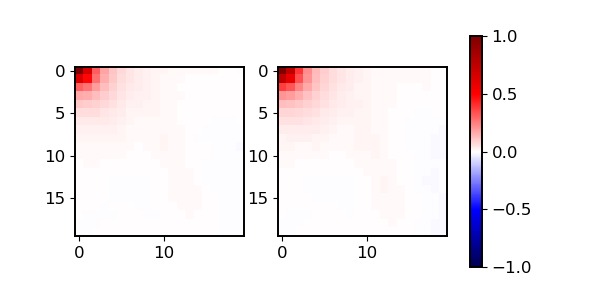

In [104]:
# Plot data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
z0 = ax[0].imshow(CA, cmap='seismic', vmin=-1, vmax=1)
z1 = ax[1].imshow(CV, cmap='seismic', vmin=-1, vmax=1)
fig.colorbar(z0, ax=ax)

In [216]:
folders = [r'D:\Wei\Dynamics_raw\cav_result_50\20',
           r'D:\Wei\Dynamics_raw\cav_result_50\40',
           r'D:\Wei\Dynamics_raw\cav_result_50\60',
           r'D:\Wei\Dynamics_raw\cav_result_50\80',
           r'D:\Wei\Dynamics_raw\cav_result_50\100']
for folder in folders:
    subdata = average_cav(folder)

In [209]:
data.to_csv(r'I:\Google Drive\Research projects\DF\Figures\fig4-VACorr\scalar100.csv', index=False)

Text(0, 0.5, 'orientation correlation')

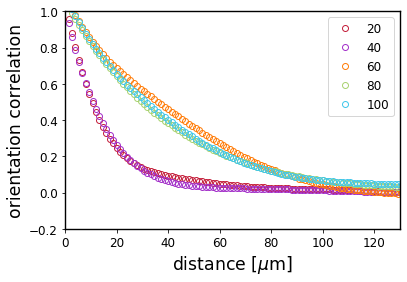

In [25]:
mpp = 0.33
sparcity = 4
deg = 15
folder = r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr'
l = dirrec(folder, 'CA*')
clA = []
count = 0
for d in l:
    dc = pd.read_csv(d)
    clA.append(corrlength(dc, 8))
    x = np.array(dc.R)-33.35
    y = dc.C
    p = np.polyfit(x, y, deg)
    xfit = np.linspace(0, 400, int(400/sparcity))
    yfit = np.dot(polyvander(xfit, deg), np.flip(p).transpose())
    plt.plot(xfit*mpp, yfit, mec=wowcolor(count), ls='',
            marker='o', mfc=(0,0,0,0))
    count += 1
plt.legend(['20', '40', '60', '80', '100'])
plt.axis([0, 130, -0.2, 1])
plt.xlabel('distance [$\mu$m]')
plt.ylabel('orientation correlation')

Text(0, 0.5, 'velocity correlation')

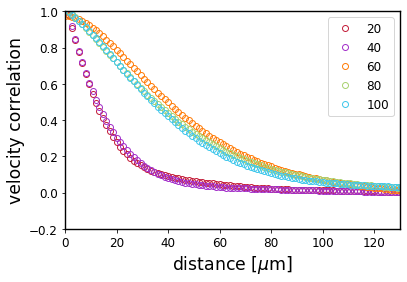

In [26]:
mpp = 0.33
folder = r'I:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr'
l = dirrec(folder, 'CV*')
clV = []
count = 0
for d in l:
    dc = pd.read_csv(d)
    clV.append(corrlength(dc, 8))
    x = np.array(dc.R)-33.35
    y = dc.C
    p = np.polyfit(x, y, deg)
    xfit = np.linspace(0, 400, int(400/sparcity))
    yfit = np.dot(polyvander(xfit, deg), np.flip(p).transpose())
    plt.plot(xfit*mpp, yfit, mec=wowcolor(count), ls='',
            marker='o', mfc=(0,0,0,0))
    count += 1
plt.legend(['20', '40', '60', '80', '100'])
plt.axis([0, 130, -0.2, 1])
plt.xlabel('distance [$\mu$m]')
plt.ylabel('velocity correlation')

Text(0, 0.5, 'correlation length [$\\mu$m]')

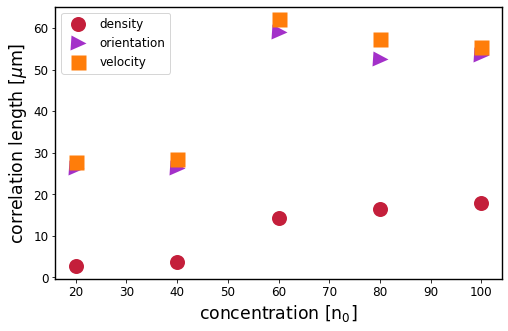

In [36]:
# plot correlation length
plt.figure(figsize=(8, 5))
n = [20, 40, 60, 80, 100]
plt.plot(n, np.array(cl)*mpp, ls='', marker='o', mfc=wowcolor(0), mec=(0,0,0,0),
        markersize=15, lw='2')
plt.plot(n, np.array(clA)*mpp, ls='', marker='>', mfc=wowcolor(1), mec=(0,0,0,0),
        markersize=15, lw='2')
plt.plot(n, np.array(clV)*mpp, ls='', marker='s', mfc=wowcolor(2), mec=(0,0,0,0),
        markersize=15, lw='2')
plt.legend(['density', 'orientation', 'velocity'])
plt.xlabel('concentration [n$_0$]')
plt.ylabel('correlation length [$\mu$m]')

#### Figure 5 - what drives concentration fluctuations?
* concentration field $c$
* source field $\nabla \cdot (c\boldsymbol{n})$

##### Derive the numerical form of source field $\nabla \cdot (c\boldsymbol{n})$
<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
$$\partial_icn_i=c\partial_in_i+n_i\partial_ic$$

$$ \nabla \cdot (c\boldsymbol{n}) = c_{x,y}\frac{n^x_{x+1,y}-n^x_{x,y}}{1} + n^x_{x, y}\frac{c_{x+1, y}-c_{x, y}}{1}+$$

$$  c_{x,y}\frac{n^y_{x,y+1}-n^y_{x,y}}{1} + n^y_{x, y}\frac{c_{x, y+1}-c_{x, y}}{1}$$

assume the unit of $c$ is n$_0$, the unit of $\nabla$ is $l_{step}^{-1}$,  $\nabla \cdot (c\boldsymbol{n})$ has a unit of n$_0l_{step}^{-1}$.

Here, the absolute value of concentration $c$ is needed, which is not accessible experimentally due to unknown $I_0$ in Beer-Lambert's Law. Nonetheless, we have information on the relative concentration at different places. This allow us to depict the concentration distribution qualitatively. 

Assume that $I_0=255$.

In [2]:
# load data
pivData = pd.read_csv(r'D:\Wei\Dynamics_raw\piv_result_50\80\900-901.csv')
img = io.imread(r'D:\Wei\Dynamics_raw\80\900.tif')
bp = bpass(img, 3, 100)
bp_mh = match_hist(bp, img)
winsize = 50
step = 25
X, Y, I = divide_windows(bp_mh, windowsize=[winsize, winsize], step=step)

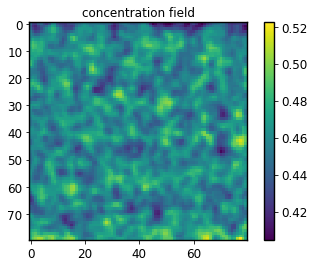

In [3]:
# concentration field
I0 = 255
c = np.log(I0/I)
plt.imshow(c)
plt.title('concentration field')
plt.colorbar()

In [26]:
row, col = I.shape
nx = np.array(pivData.u / (pivData.u**2 + pivData.v**2)**.5).reshape(I.shape)
ny = np.array(pivData.v / (pivData.u**2 + pivData.v**2)**.5).reshape(I.shape)
divcn = np.zeros(I.shape)
for x in range(0, col-1):
    for y in range(0, row-1):
        divcn[y, x] = c[y, x] * (nx[y,x+1] - nx[y,x]) + nx[y,x] * (c[y,x+1] - c[y,x]) + \
                      c[y, x] * (ny[y+1,x] - ny[y,x]) + ny[y,x] * (c[y+1,x] - c[y,x])

<IPython.core.display.Javascript object>


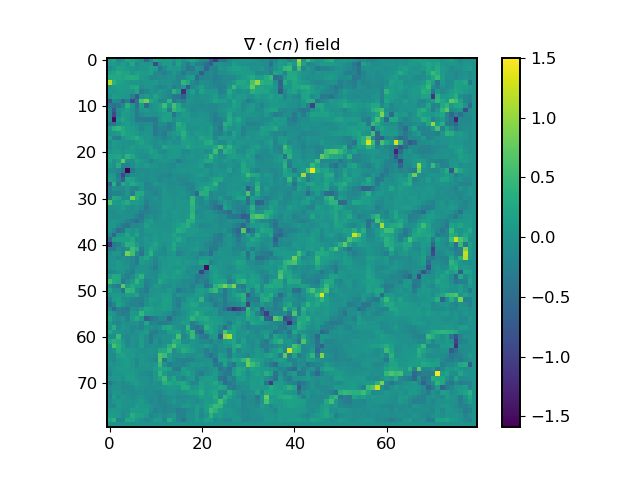

In [41]:
plt.imshow(divcn)
plt.title('$\\nabla\cdot(cn)$ field')
plt.colorbar()

##### Alternative way for calculating $\nabla \cdot (c\boldsymbol{n})$
* $c\boldsymbol{n}$
* take divergence

In [5]:
row, col = I.shape
nx = np.array(pivData.u / (pivData.u**2 + pivData.v**2)**.5).reshape(I.shape)
ny = np.array(pivData.v / (pivData.u**2 + pivData.v**2)**.5).reshape(I.shape)
cnx = c * nx
cny = c * ny
divcn = np.zeros(I.shape)
for x in range(0, col-1):
    for y in range(0, row-1):
        divcn[y, x] = cnx[y,x+1] - cnx[y,x] + cny[y+1,x] - cny[y,x]

In [10]:
c-c.mean()

array([[-0.01594653, -0.03236926, -0.034617  , ..., -0.03244146,
        -0.03948698, -0.04237666],
       [-0.02209293, -0.03814549, -0.04307932, ..., -0.03125674,
        -0.0477401 , -0.05437302],
       [-0.01599546, -0.03140852, -0.03956823, ..., -0.03040345,
        -0.0435102 , -0.04987793],
       ...,
       [ 0.01770559,  0.02537642,  0.02947977, ...,  0.01404842,
         0.02111464,  0.01203361],
       [ 0.01639828,  0.0272676 ,  0.03398059, ...,  0.02899344,
         0.02475447,  0.00694417],
       [ 0.01850548,  0.03385715,  0.04059655, ...,  0.06191643,
         0.03954343,  0.01639576]])

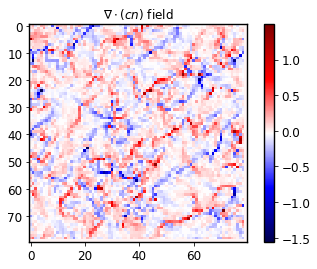

In [7]:
plt.imshow(divcn-divcn.mean(), cmap='seismic')
plt.title('$\\nabla\cdot(cn)$ field')
plt.colorbar()

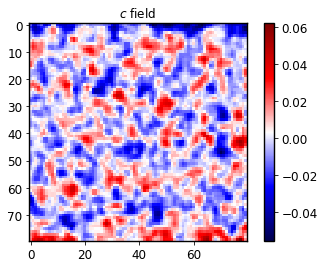

In [8]:
plt.imshow(c-c.mean(), cmap='seismic')
plt.title('$c$ field')
plt.colorbar()

Turns out the result is the same.